# Attention mechanisms

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import torch.utils.data.dataloader as dataloader

import torch.nn.functional as F

from tqdm.notebook import trange, tqdm

In [2]:
# Define the root directory of the dataset
data_set_root = "../../datasets"

# Define transformations to be applied to the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.5], [0.5])  # Normalize image data with mean 0.5 and standard deviation 0.5
])

# Load the MNIST dataset
dataset = datasets.MNIST(data_set_root, train=True, download=True, transform=transform)

# Specify the number of examples to select randomly
num_of_examples = 100

# Randomly select indices from the dataset
rand_perm = torch.randperm(dataset.data.shape[0])[:num_of_examples]

# Extract and concatenate the images of randomly selected examples into a tensor
dataset_tensor = torch.cat([dataset.__getitem__(i)[0].reshape(1, -1) for i in rand_perm])

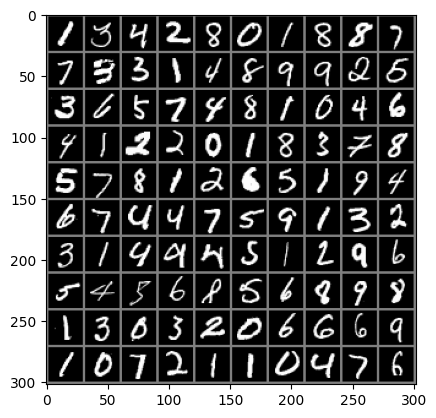

In [3]:
# Lets visualise the images
out = torchvision.utils.make_grid(dataset_tensor.reshape(-1, 1, 28, 28), 10, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

## Indexing data

In [8]:
q_index = 10

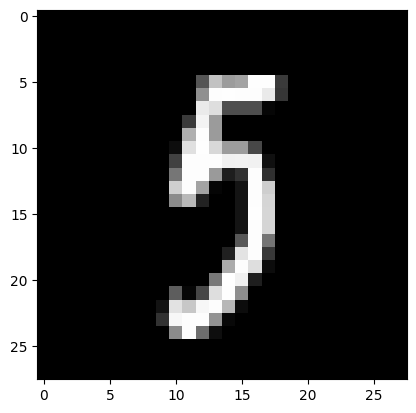

In [9]:
plt.figure()\

_ = plt.imshow(dataset_tensor[q_index].reshape(28, 28).numpy(), cmap = 'grey')

## Indexing using matrix multiplication
Query, Key, Value vectors

In [10]:
# We can use matrix multiplication in order to retrieve information without implicitly querying by using one-hot vectors

q_one_hot = F.one_hot(torch.tensor([q_index]), num_of_examples)
print(q_one_hot.shape)
q_one_hot

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [12]:
# In order to query each data point we can create a key matrix that correspondingly shows each data point place in a data set (a matrix of one-hot vectors)
k_one_hot = F.one_hot(torch.arange(num_of_examples), num_of_examples)

# Key matrix can be either identity matrix or random matrix that consists of vectors that are orthogonal (dot-product = 0) with query vectors
print(k_one_hot.shape)
k_one_hot

torch.Size([100, 100])


tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1]])

In [13]:
# Randomly shuffle the keys and dataset to demonstrate that we can find the target image
# even in a randomly organized dataset
rand_perm = torch.randperm(num_of_examples) # Shuffle data indexes (create new order for one-hot vectors)
k_one_hot = k_one_hot[rand_perm] # Reorder key matrix
dataset_tensor_random = dataset_tensor[rand_perm]

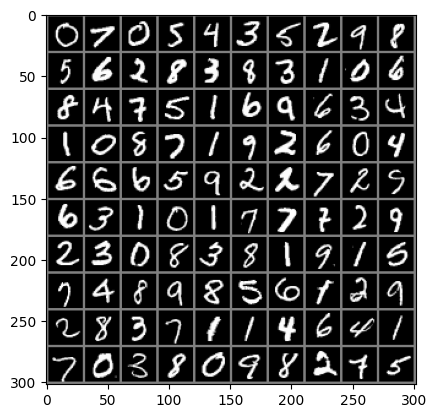

In [18]:
# Dataset until random permutation
out = torchvision.utils.make_grid(dataset_tensor.reshape(-1, 1, 28, 28), 10, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

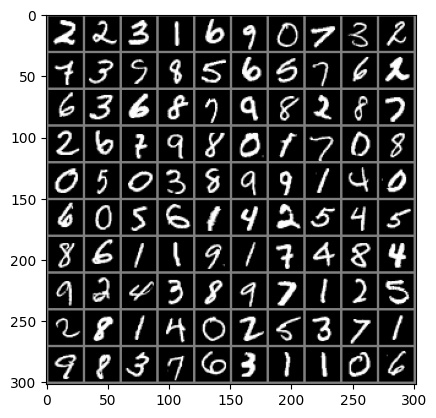

In [19]:
# Dataset after random permutation
out = torchvision.utils.make_grid(dataset_tensor_random.reshape(-1, 1, 28, 28), 10, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [31]:
# Multiply key vector
index_map = torch.mm(q_one_hot, k_one_hot.T).float()
index_map

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [33]:
# Retrieve desired vector
output = torch.mm(index_map, dataset_tensor_random)

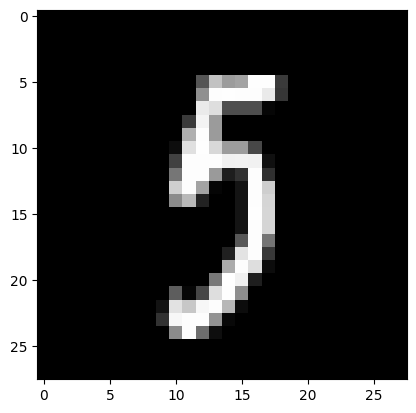

In [34]:
plt.figure()\

_ = plt.imshow(output.reshape(28, 28).numpy(), cmap = 'grey')

The desired mechanism operates as lookup through matrix multiplication. However hard-coded one-hot vectors can not be properly propagated, because of zero values.

## Attention as a "Soft" Look-up

In order to eliminate troubles while using one-hot vectors we can use a more simple way to create a trainable mechanism. Suppose using randomly distributed values that were drawn from normal distribution (same order and magnitude).

In [87]:
# Can be smaller than actual data set shape
vec_size = 128

Eliminating vector size lowers vector's possibility to transfer quite big amount of data that could be informative in order to transfer valuable information. That creates a situation where each query can be aligned with multiple keys, which could lead to a much more confusing situation like there exist multiple datapoints that align perfectly with the desired key.

In [88]:
# Random query vector
q_random_vec = torch.randn(1, vec_size)
q_random_vec

tensor([[-0.5804, -1.7615,  1.2936,  2.2395,  0.4598,  1.0084,  0.1709,  0.6360,
         -0.4762, -1.0050,  0.1331, -1.1735, -0.1510,  1.3995,  0.1273,  0.3281,
          0.1355,  0.2623, -1.4769, -0.5717,  1.2859,  1.8801, -0.0858,  0.2725,
          0.0928,  1.3078,  0.7570,  1.1528, -1.4049,  0.0520,  1.9201, -0.0491,
         -0.0573,  0.3992, -0.4533,  0.4580,  0.0867, -0.6178, -0.2701,  0.3926,
          0.1555, -1.3492,  0.5379, -0.3881, -0.3651,  1.1863, -0.1178, -0.1046,
          0.2648, -1.2632, -0.4311,  1.3544, -0.0109,  0.6323, -0.4718, -0.3517,
         -0.7226,  0.1601, -1.6915,  0.1229,  0.1991,  1.2785, -1.2351, -0.2331,
         -1.1019, -0.1100, -0.2114, -0.0848, -0.1586, -0.3755,  1.7709, -0.1373,
         -0.0457,  0.3941, -1.0351, -1.3347, -0.2133,  1.1014,  0.1023, -0.0787,
         -0.7016,  0.1188, -1.7031,  0.6109, -1.2590,  0.2266, -1.3129, -0.4030,
          0.4267,  2.1330,  0.8888,  0.6999,  0.1435, -0.7575,  0.6653, -0.9522,
         -0.2251,  1.2771,  

In [89]:
# Random key matrix for each data point in the dataset
random_keys = torch.randn(num_of_examples, vec_size)
random_keys.shape

torch.Size([100, 128])

In [90]:
# Calculate and attention map using matrix multiplication
attention_map = torch.mm(q_random_vec, random_keys.T).float()

attention_map = F.softmax(attention_map, 1)

Softmaxxing an attention map transforms resulting vector into a vector, which total sum of elements equals to nearly one. Also this transformation forces vector to be of all positive values.

In [91]:
attention_map.sum(1)

tensor([1.])

In [92]:
# Using attention map perform soft-indexing over a dataset
output = torch.mm(attention_map, dataset_tensor_random)

In [93]:
print('Largest Softmax value', attention_map.max().item())

Largest Softmax value 0.999868631362915


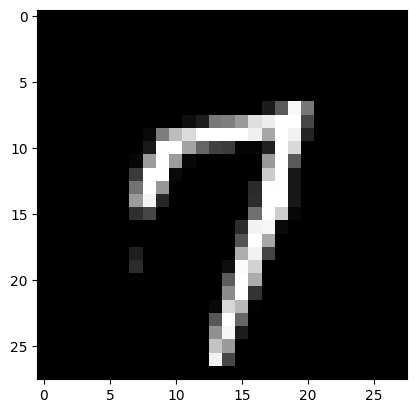

In [94]:
plt.figure()\

_ = plt.imshow(output.reshape(28, 28).numpy(), cmap = 'grey')

## Multiple queries

Earlier presented mechanism can be implemented to work with multiple queries simultaneously because of a quite optimal matrix multiplication operations.

In [106]:
# Can be smaller than actual data set shape
vec_size = 512

In [107]:
# Random queries vector
num_q = 8

q_random_vec = torch.randn(num_q, vec_size)
print(q_random_vec.shape)
q_random_vec

torch.Size([8, 512])


tensor([[-1.0765, -0.7699, -1.1072,  ..., -1.0037, -3.0945, -1.1993],
        [-0.9310, -0.4224, -0.3398,  ...,  1.1316,  0.2370,  2.1515],
        [-0.7622,  1.5310, -0.5024,  ...,  1.1474, -0.4997,  0.8672],
        ...,
        [-1.7959, -2.3016,  0.6191,  ..., -0.2358,  0.1272, -0.1357],
        [-0.1358, -0.4696, -2.0835,  ..., -0.7456,  1.4648, -1.0318],
        [-1.5097, -0.6948,  2.1028,  ...,  1.0259, -0.4893,  0.0195]])

In [108]:
# Random key matrix for each data point in the dataset
random_keys = torch.randn(num_of_examples, vec_size)
random_keys.shape

torch.Size([100, 512])

In [109]:
# Calculate and attention map using matrix multiplication
attention_map = torch.mm(q_random_vec, random_keys.transpose(0, 1)).float()

attention_map = F.softmax(attention_map, -1)

In [110]:
attention_map.sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [111]:
# Using attention map perform soft-indexing over a dataset
output = torch.mm(attention_map, dataset_tensor_random)

In [114]:
output.shape

torch.Size([8, 784])

In [112]:
print('Largest Softmax values', attention_map.max(-1))

Largest Softmax values torch.return_types.max(
values=tensor([0.9729, 0.9999, 0.9999, 1.0000, 1.0000, 0.6991, 1.0000, 1.0000]),
indices=tensor([82, 53, 50, 66, 21,  2, 45, 85]))


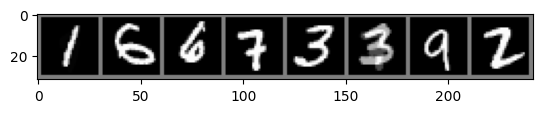

In [113]:
out = torchvision.utils.make_grid(output.reshape(num_q, 1, 28, 28), 8, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

## Multi-headed attention

Multi-headed attention creates a bigger (multi-batch) indexing mechanism that creates multiple matrices representing all necessary `Query-Keys` matrix pairs.

In [149]:
# Can be smaller than actual data set shape
vec_size = 512

# Number of queries
num_q = 8

# Number of heads
num_heads = 4

q_random_vec = torch.randn(num_heads, num_q, vec_size) # [4 heads, 8 queries in each, 128 each query vector size]

print(q_random_vec.shape)
q_random_vec

torch.Size([4, 8, 512])


tensor([[[ 0.9825, -1.8625,  0.1437,  ..., -0.8323,  1.0857,  1.8653],
         [ 0.5269, -0.3428, -1.6890,  ...,  0.4150, -0.9247,  1.5381],
         [ 1.8722,  0.7190,  0.6643,  ..., -0.2327,  1.4308, -0.2924],
         ...,
         [-0.6723, -0.8634, -0.4906,  ...,  1.4838,  0.6846,  0.7929],
         [-1.1555,  1.6790, -0.7302,  ..., -1.2083, -0.5810,  0.4325],
         [ 0.6658,  0.7535, -2.5653,  ..., -0.2405, -0.2178, -1.2963]],

        [[ 1.6224, -1.0444, -0.3386,  ...,  0.8725, -0.8336, -0.0877],
         [ 0.9870,  0.9937,  0.0993,  ...,  0.4949, -0.1367,  0.8230],
         [ 0.5790,  1.1752,  0.7758,  ...,  1.8936,  0.2852,  0.5224],
         ...,
         [-0.5256,  0.7955,  0.1617,  ..., -0.8114, -0.4406,  0.9802],
         [-1.1030,  0.5986,  0.6902,  ...,  0.6974,  0.3703,  0.0321],
         [ 0.0096, -0.3899, -0.0837,  ..., -0.8785, -1.1475, -0.7769]],

        [[-0.0418,  0.9772, -0.2591,  ...,  0.4607,  1.1087,  0.3875],
         [ 0.1574,  0.1914,  1.2073,  ..., -1

In [150]:
# Random key matrix for each data point in the dataset
random_keys = torch.randn(num_heads, num_of_examples, vec_size)
random_keys.shape

torch.Size([4, 100, 512])

In [151]:
# Calculate and attention maps using batch matrix multiplication
# Transpose causes changes in inner dimensions in order to comply with matrix multiplication rules inside each specific batch

attention_map = torch.bmm(q_random_vec, random_keys.transpose(1, 2)).float()

attention_map = F.softmax(attention_map, 2)

In [152]:
attention_map.shape

torch.Size([4, 8, 100])

In [153]:
attention_map.sum(-1)

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]])

In [154]:
tmp = dataset_tensor.unsqueeze(0).expand(num_heads, num_of_examples, -1)
tmp[0] == tmp[1]

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [155]:
'''
Using attention map perform soft-indexing over a dataset

Combination of unsqueeze and expand dims is necessary to comply with dimensions of QKt matrices: 
dataset_tensor.unsqueeze(0).expand(num_heads, num_of_examples, -1)

- Unsqueeze tranforms dataset_tensor from [100, 784] -> [1, 100, 784]
- Expand creates multiple batches of equal matrices [1, 100, 784] -> [4, 100, 784]
'''

output = torch.bmm(attention_map, dataset_tensor.unsqueeze(0).expand(num_heads, num_of_examples, -1))
output.shape

torch.Size([4, 8, 784])

In [156]:
print('Largest Softmax values', attention_map.sum(-1))

Largest Softmax values tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]])


In [157]:
out_reshape = output.reshape(num_heads, num_q, 28, 28).transpose(1, 2).reshape(num_heads, 1, 28, num_q*28)

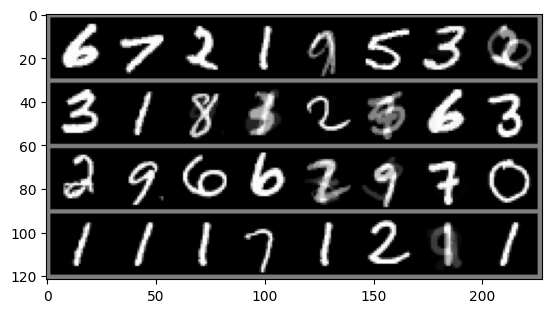

In [158]:
out = torchvision.utils.make_grid(out_reshape, 1, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [159]:
out_reshape.shape

torch.Size([4, 1, 28, 224])

## Pytorch Multi-Head Attention

In [10]:
# Can be smaller than actual data set shape
vec_size = 64

# Number of heads
num_heads = 4

# Batch size = 32
batch_size = 32

# Batch of a single random query 
query = torch.randn(batch_size, 1, num_heads * vec_size) 
print('Q shape', query.shape)

# Batch of random key vectors for each image in data set 
key = torch.randn(batch_size, num_of_examples, num_heads * vec_size) 
print('K shape', key.shape)

# Batch of random value vectors for each image in data set 
value = torch.randn(batch_size, num_of_examples, num_heads * vec_size) 
print('V shape', value.shape)

multihead_attn = nn.MultiheadAttention(num_heads * vec_size, num_heads, batch_first=True) 
# Each head will have dimension embed_dim // num_heads
# Keys and Values dimensions can be explicitly stated using kdim, vdim params of a MultiheadAttention

Q shape torch.Size([32, 1, 256])
K shape torch.Size([32, 100, 256])
V shape torch.Size([32, 100, 256])


In [11]:
# Forward pass of multihead attention

attn_output, attn_output_weights = multihead_attn( query, key, value, average_attn_weights = False)

Using `average_attn_weights` do0wnsamples attention output weights and creates only one matrix that contains averaged head's projections.

In [12]:
# Print the shapes of the output of the forward pass from Multi-Head Attention module

# Softmaxed "attention mask" shape
print("Softmax Attention Mask:", attn_output_weights.shape)

# Attention output shape
print("Attention Output:", attn_output.shape)

Softmax Attention Mask: torch.Size([32, 4, 1, 100])
Attention Output: torch.Size([32, 1, 256])


Softmax Attention Mask: torch.Size([32, 4, 1, 100]) - `attn_output_weights` - are learnable parameters that are matrices used to process Q, K, V matrices.

*32 Batches that contain attention weights from 4 attention heads about 1 query vector that attends to 100 elements in an input sequence.*
- 32 - Number of batches;
- 4 - Number of heads prediction matrices;
- 1 - Number of query vectors;
- 100 - Number of all samples in the input sequence.

`attn_output` - is equal to attention map;
Attention Output: torch.Size([32, 1, 256]) - 32 batches containing inforamtion about one query vector, which embedding size is `batch_size * num_heads`.

In [13]:
# Each query/key/value vector is passed through a "projection" aka a learnable linear layer before
# the attention mechanism 
# As they are all the same size Pytorch creates a single block of parameters splits it into 3 beacuse 3 is number of count(Q, K, V)
# Before doing a forward pass of each*
print("Projection weight size", multihead_attn.in_proj_weight.shape)

# *Most of the time, doing a deep dive into the implementation Pytorch tries to do a lot of optimisation
# to try and be efficient as possible depending on the use-case

Projection weight size torch.Size([768, 256])


## Training Multi-headed Attention

Main task for training is to create a simple lookup model that can by using attention mechanism find most suitable objects in source dataset according to query vector.

In [17]:
class AttentionTest(nn.Module):
    def __init__(self, num_of_examples = 100, embed_dim = 784, num_heads = 4):
        super(AttentionTest, self).__init__()

        # Define an MLP for processing image data
        self.img_mlp = nn.Sequential(
            nn.Linear(784, embed_dim),   # Linear layer to embed image data into a lower-dimensional space
            nn.LayerNorm(embed_dim),     # Layer normalization to normalize the embedded features
            nn.ELU(),                    # ELU activation function for introducing non-linearity
            nn.Linear(embed_dim, embed_dim)  # Another linear transformation for further processing
        )
        
        
        self.mha = nn.MultiheadAttention(embed_dim = embed_dim,
                                        num_heads=num_heads,
                                        batch_first=True)

    def forward(self, img, values):
        # img - query vector
        # values - fixed dataset 100 samples of values (images) - will be transofrmed to a 3D tensor, but Linear layers can effectively deal with 3D tensors
        
        img_ = self.img_mlp(img)
        values_ = self.img_mlp(values)

        # Apply the Multi-Head Attention mechanism
        attn_output, attn_output_weights = self.mha(img_, values_, values_)

        # Compute the output using the attention weights and the original values
        output = torch.bmm(attn_output_weights, values)

        return output, attn_output_weights

In [18]:
# Define the dimensionality of the embedding space
embed_dim = 256

# Define the number of attention heads
num_heads = 1

# Define the batch size
batch_size = 64

In [19]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

# Create a DataLoader for training the model
train_loader = dataloader.DataLoader(
    dataset,                   # Dataset to load
    shuffle=True,              # Shuffle the data for each epoch
    batch_size=batch_size,     # Batch size for training
    num_workers=4,             # Number of processes to use for data loading
    drop_last=True             # Drop the last incomplete batch if it's smaller than the batch size
)

### Model step

In [20]:
# Create an instance of the AttentionTest model
mha_model = AttentionTest(
    num_of_examples=num_of_examples,   # Number of examples in the dataset
    embed_dim=embed_dim,               # Dimensionality of the embedding space
    num_heads=num_heads                # Number of attention heads
).to(device)                           # Move the model to the specified device

# Define the Adam optimizer for training the model
optimizer = optim.Adam(
    mha_model.parameters(),  # Parameters to optimize
    lr=1e-4                   # Learning rate
)

# List to store the training loss for each epoch
loss_logger = []

In [28]:
values_tensor = dataset_tensor.unsqueeze(0)
print('Create higher dimension representing batch', values_tensor.shape)

# Duplicate the data value tensor for each batch element and move it to the specified device
values_tensor = values_tensor.expand(batch_size, num_of_examples, -1).to(device) # -1 - don't change the original dimension
print('Crete copies of values tensor in a batch dimension', values_tensor.shape)

Create higher dimension representing batch torch.Size([1, 100, 784])
Crete copies of values tensor in a batch dimension torch.Size([64, 100, 784])


### Training

In [33]:
data, _train_loader = next(iter(train_loader))

In [43]:
print('Data before squeezing', data.shape)
print('Data after squeezing for inputs', data.reshape(data.shape[0], 1, -1).shape)

Data before squeezing torch.Size([64, 1, 28, 28])
Data after squeezing for inputs torch.Size([64, 1, 784])


In [56]:
# Set the model to training mode
mha_model.train()

# Loop through 10 epochs
for _ in trange(20, leave=False):
    # Iterate over the training data loader
    for data, _train_loader in tqdm(train_loader, leave=False):
        # Reshape the input data and move it to the specified device. Reshape is necessary to comply with attention inputs.
        q_img = data.reshape(data.shape[0], 1, -1).to(device) # Remain batches but squeeze inner matrix to a long row

        # Perform forward pass through the Multi-Head Attention model
        attn_output, attn_output_weights = mha_model(q_img, values_tensor)

        # Calculate the mean squared error loss between the output and input images
        loss = (attn_output - q_img).pow(2).mean()

        # Zero the gradients, perform backward pass, and update model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Append the current loss value to the loss logger
        loss_logger.append(loss.item())

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

Minimum MSE loss 0.1102


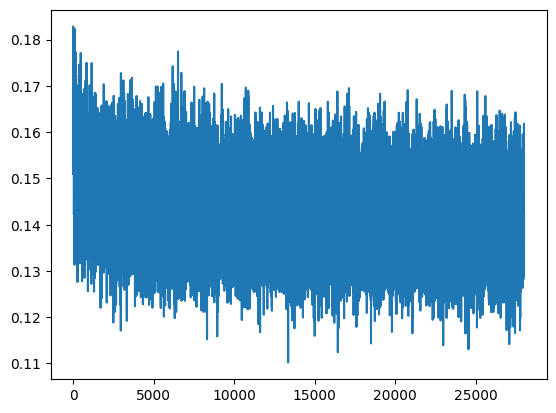

In [57]:
_ = plt.plot(loss_logger[100:])
print("Minimum MSE loss %.4f" % np.min(loss_logger))

## Using the model

In [62]:
# Set the model to evaluation mode
mha_model.eval()

# Perform forward pass without gradient computation
with torch.no_grad():
    # Reshape input data and move it to the specified device
    q_img = data.reshape(data.shape[0], 1, -1).to(device)

    # Perform forward pass through the Multi-Head Attention model
    attn_output, attn_output_weights = mha_model(q_img, values_tensor)

In [66]:
# For a given input, use the attention map to find the "closest" value-data matches
index = 54
top10 = attn_output_weights[index, 0].argsort(descending=True)[:10]
top10_data = values_tensor[index, top10].cpu()

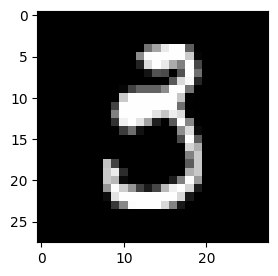

In [67]:
# Plot the original image
plt.figure(figsize=(3, 3))
out = torchvision.utils.make_grid(q_img[index].cpu().reshape(-1, 1, 28, 28), 8, 
                                  normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

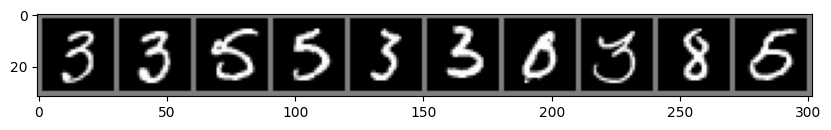

In [68]:
# Plot the top 10 closest matches
plt.figure(figsize=(10, 10))
out = torchvision.utils.make_grid(top10_data.reshape(-1, 1, 28, 28), 10, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

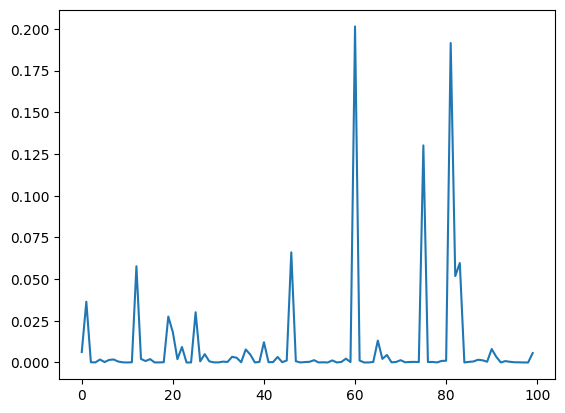

In [69]:
# Plot the attention weights for the given input
_ = plt.plot(attn_output_weights[index, 0].cpu().numpy().flatten())

In [70]:
# Reshape the target and returned images
target_img = q_img.reshape(batch_size, 1, 28, 28)
indexed_img = attn_output.reshape(batch_size, 1, 28, 28)

# Stack the images with the returned image on top
img_pair = torch.cat((indexed_img, target_img), 2).cpu()

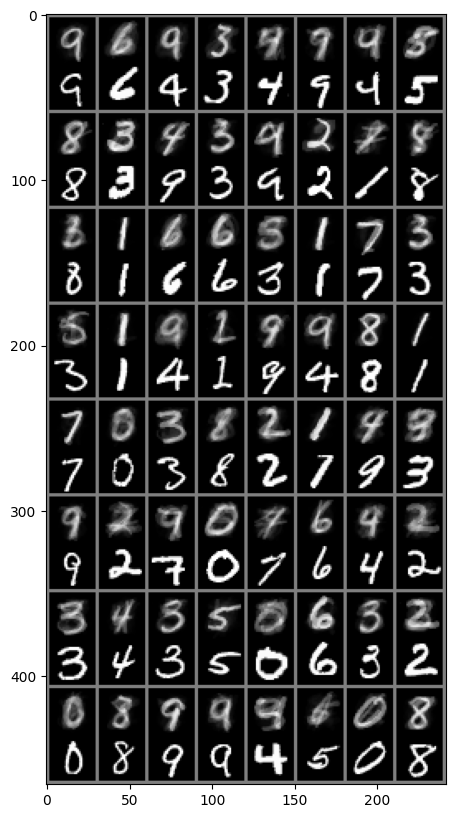

In [71]:
# Let's visualize the pairs of images, with the returned image on top and the target on bottom
plt.figure(figsize=(10, 10))
out = torchvision.utils.make_grid(img_pair, 8, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))